In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy   as np
import sklearn as skl

import matplotlib.pyplot as plt
import seaborn           as srn

from sklearn.model_selection       import train_test_split
from sklearn.svm                   import OneClassSVM
from sklearn.kernel_approximation  import Nystroem
from sklearn.neighbors             import KernelDensity
from sklearn.model_selection       import GridSearchCV
from sklearn.metrics               import pairwise_distances
from scipy.stats                   import beta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generate samples from a Beta(2, 2) distribution.

In [3]:
np.random.seed(42)
N = 10**4

X     = beta.rvs(a = 2, b = 2, size = N)[:,np.newaxis]
pStar = lambda x: beta.pdf(x, a = 2, b = 2)

XTr, XTe = train_test_split(X, train_size = 0.80, test_size = 0.20, random_state = 42)
XTe      = XTe[np.argsort(XTe.flatten()),:]

Compute an optimal bandwidth for the RBF kernel using cross-validation, with log-likelihood of density estimation as the target to maximise. Using the median distance between points as an anchor for constructing a grid of possible bandwidths.

In [4]:
D = pairwise_distances(X, X).flatten()

params = { 'bandwidth' : [ np.percentile(D, q = 50) * 2**x for x in np.arange(-5, +3 + 0.5, 0.5) ] }
grid   = GridSearchCV(KernelDensity(), params)
grid.fit(X[:1000, :]) # sub-sample 1000 points for tractability
kde  = grid.best_estimator_

Convert the bandwidth of the form $e^{-\| x - x' \|^2/2h^2}$ into one of the form $e^{-\gamma \| x - x' \|^2}$.

In [5]:
gam0 = 1/np.median(pairwise_distances(XTr, XTr)**2)
gMed = 0.5 / kde.bandwidth**2

Fit a OC-SVM with RBF kernel, targetting the 10% density threshold.

In [6]:
ocsvm = OneClassSVM(nu = 0.10, kernel = 'rbf', gamma = gMed)
ocsvm.fit(XTr)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=647.78506363515817,
      kernel='rbf', max_iter=-1, nu=0.1, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

Plot the true density, the 10% quantile threshold for the density, and the OC-SVM predictions.

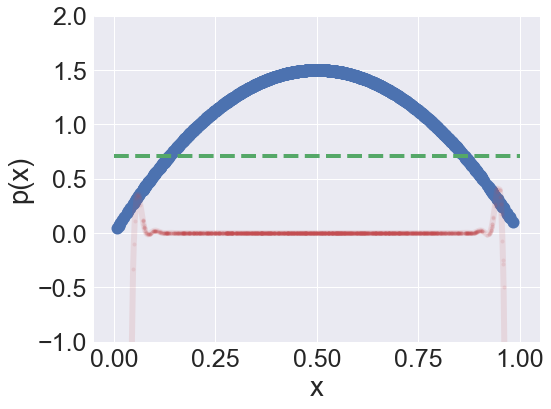

In [8]:
srn.set(font_scale = 2.5);
plt.figure(figsize = (8,6));

rStar = np.percentile(pStar(XTe), q = 100 * 0.10)

plt.plot(XTe, pStar(XTe),                        '.-', linewidth=8, markersize=24);
plt.plot([0,1], [rStar,rStar],                   '--', linewidth=4, markersize=24);
plt.plot(XTe, ocsvm.decision_function(XTe),      '.-', linewidth=6, markersize=8, alpha=0.125);
plt.ylim((-1, 2))
plt.xlabel('x'); plt.ylabel('p(x)');
plt.savefig('beta_test.pdf', bbox_inches = 'tight');